In [1]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.optimize
from scipy.optimize import minimize
from scipy.special import jv
#from scipy.ndimage import gaussian_filter1d
import sys

import qgm
from qgm import image, parameter, filter, data, fitting, function

from regions import PixCoord, RectanglePixelRegion, CirclePixelRegion

cmap = image.generate_cmap(['#330000', 'r', 'w'])

In [2]:
date = '20220725'
dataNo = 1
scanNo = 1

In [3]:
path = r"./"+date
path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [5]:
param_name_1 = 'A0138: LS Freq. 1'
param_name_2 = 'A0157: OL (H1): AM for physics 2'
scan_param_1 =scan_data[param_name_1]
scan_param_2 =scan_data[param_name_2]
unique_param_1 = scan_param_1.unique()
unique_param_2 = scan_param_2.unique()
sample1 = [unique_param_1[0], unique_param_2[0]]
sample2 = [unique_param_1[15], unique_param_2[0]]
sample3 = [unique_param_1[30], unique_param_2[0]]
flcount = scan_data['Total count @ ROI1 (arb. u.)']
logNum = scan_data['Log No.']

In [6]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat.tiff'))
    update_files = list(Path(path_img).glob('seq*_update.tiff'))
else:
    print('No images')

img_flat_ave =[]
img_trans_ave = []
img_trans_list = []
for N in range(len(trans_files)):
    img_flat_ave += [np.array(Image.open(flat_files[N]))]
    img_trans_ave += [np.array(Image.open(trans_files[N]))]
img_flat_ave = np.average(img_flat_ave,axis=0)
img_trans_ave =np.average(img_trans_ave,axis=0) -img_flat_ave
for N in range(len(trans_files)):
    img_trans_list += [np.array(Image.open(trans_files[N])) - img_flat_ave]

In [11]:
dataNumbersToBeRemoved = [[1285,2169],[8088,8465]]

In [18]:
postSelected_param_1 = []
postSelected_param_2 = []
postSelected_trans_files = []
for i in range(len(trans_files)):
    if i<dataNumbersToBeRemoved[0][0] or dataNumbersToBeRemoved[0][1]<i<dataNumbersToBeRemoved[1][0] or i>dataNumbersToBeRemoved[1][1]:
        postSelected_param_1.append(scan_param_1[i])
        postSelected_param_2.append(scan_param_2[i])
        postSelected_trans_files.append(img_trans_list[i])

In [19]:
np.shape(postSelected_trans_files)

(9515, 512, 512)

In [49]:
img_trans_sample1 = []
img_trans_sample2 = []
img_trans_sample3 = []
for i in range(len(postSelected_trans_files)):
        if [postSelected_param_1[i], postSelected_param_2[i]] == sample1:
            img_trans_sample1 += [postSelected_trans_files[i]]
        elif [postSelected_param_1[i], postSelected_param_2[i]] == sample2:
            img_trans_sample2 += [postSelected_trans_files[i]]
        elif [postSelected_param_1[i], postSelected_param_2[i]] == sample3:
            img_trans_sample3 += [postSelected_trans_files[i]]
img_trans_sample1 = np.average(img_trans_sample1,axis=0) 
img_trans_sample2 = np.average(img_trans_sample2,axis=0) 
img_trans_sample3 = np.average(img_trans_sample3,axis=0)

Text(0.5, 1.0, 'A0138: LS Freq. 1 = 6400.0\nA0157: OL (H1): AM for physics 2=5.702')

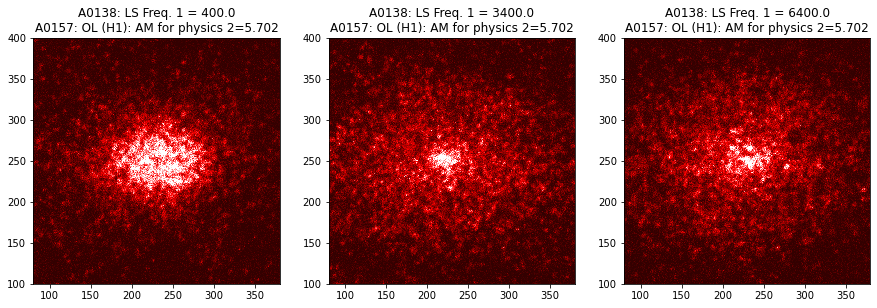

In [52]:
vmin = 0
vmax = 1000
xlim_1 = 80
xlim_2 = 380
ylim_1 = 100
ylim_2 = 400

fig =plt.figure(figsize=[15,10])
ax1 = fig.add_subplot(2,3,1)
mappable =ax1.pcolormesh(img_trans_sample1, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title(param_name_1+ " = %.01f"%(sample1[0])+'\n'+param_name_2+"=%.03f"%(sample1[1]))

ax2 = fig.add_subplot(2,3,2)
mappable =ax2.pcolormesh(img_trans_sample2, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
ax2.set_aspect('equal')
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_ylim(ylim_1,ylim_2)
ax2.set_title(param_name_1+ " = %.01f"%(sample2[0])+'\n'+param_name_2+"=%.03f"%(sample2[1]))

ax3 = fig.add_subplot(2,3,3)
mappable =ax3.pcolormesh(img_trans_sample3, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
ax3.set_aspect('equal')
ax3.set_xlim(xlim_1,xlim_2)
ax3.set_ylim(ylim_1,ylim_2)
ax3.set_title(param_name_1+ " = %.01f"%(sample3[0])+'\n'+param_name_2+"=%.03f"%(sample3[1]))

In [53]:
change = True
while change:
    change = False
    for i in range(len(unique_param_1)-1):
        if unique_param_1[i]>unique_param_1[i+1]:
            unique_param_1[i], unique_param_1[i+1] = unique_param_1[i+1], unique_param_1[i]
            change = True

change = True
while change:
    change = False
    for i in range(len(unique_param_2)-1):
        if unique_param_2[i]>unique_param_2[i+1]:
            unique_param_2[i], unique_param_2[i+1] = unique_param_2[i+1], unique_param_2[i]
            change = True

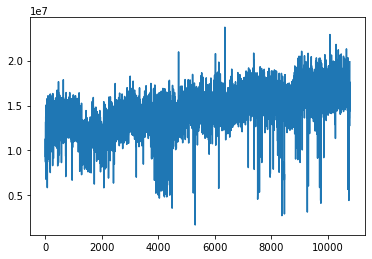

In [57]:
flcount = scan_data['Total count @ ROI1 (arb. u.)']
plt.plot(flcount)

In [88]:
unique_param_indices = [len(unique_param_1)-1,0]

def createUniqueTransFiles(img_trans_list, scan_param_1, scan_param_2, unique_param_1, unique_param_2, unique_param_indices):
    unique_trans_files = []
    for i in range(len(img_trans_list)):
        if scan_param_1[i] == unique_param_1[unique_param_indices[0]] and scan_param_2[i] == unique_param_2[unique_param_indices[1]]:
            unique_trans_files.append(img_trans_list[i])
    return unique_trans_files

unique_trans_files = createUniqueTransFiles(postSelected_trans_files, postSelected_param_1, postSelected_param_2, unique_param_1, unique_param_2, unique_param_indices)

In [89]:
cx = 232
cy = 248
r = 13
momentum_peaks_C2_dx_list = [61.739685907663, -61.739685907663,75.537038836463,-75.537038836463, 13.7973529288, -13.7973529288]
momentum_peaks_C2_dy_list = [-51.577235133566,51.577235133566,27.679518850925, -27.679518850925, 79.256753984491, -79.256753984491]
momentum_peaks_C1_dx_list = [79.256753984491, -79.256753984491, 27.679518850925, -27.679518850925, -51.577235133566, 51.577235133566]
momentum_peaks_C1_dy_list = [-13.7973529288, 13.7973529288, -75.537038836463, 75.537038836463, -61.739685907663, 61.739685907663]

def calculateCentersOfSubROI(cx, cy, momentum_peaks_C1_dx_list, momentum_peaks_C1_dy_list, momentum_peaks_C2_dx_list, momentum_peaks_C2_dy_list):
    shift_dx_list = []
    shift_dy_list = []
    list(map(lambda x: shift_dx_list.extend(x), ([0],momentum_peaks_C1_dx_list, momentum_peaks_C2_dx_list)))
    list(map(lambda x: shift_dy_list.extend(x), ([0],momentum_peaks_C1_dy_list, momentum_peaks_C2_dy_list)))
    subROI_cx_list = cx+np.array(shift_dx_list)
    subROI_cy_list = cy+np.array(shift_dy_list)
    return subROI_cx_list, subROI_cy_list

subROI_cx_list, subROI_cy_list = calculateCentersOfSubROI(cx, cy, momentum_peaks_C1_dx_list, momentum_peaks_C1_dy_list, momentum_peaks_C2_dx_list, momentum_peaks_C2_dy_list)

def extractCircleROI(image, subROI_cx, subROI_cy, r):
    row, column = np.shape(image)
    ii, jj = np.meshgrid(np.arange(row), np.arange(column), indexing='ij')
    d2 = np.square(ii - subROI_cy) + np.square(jj - subROI_cx)
    extractedData = np.where(d2 < r * r, image, np.nan)
    return extractedData

def OpticalDensityInExtractedCircleROI(image, subROI_cx, subROI_cy, r):
    row, column = np.shape(image)
    ii, jj = np.meshgrid(np.arange(row), np.arange(column), indexing='ij')
    d2 = np.square(ii - subROI_cy) + np.square(jj - subROI_cx)
    extractedData = np.where(d2 < r * r, image, 0)
    normalizedOD = np.sum(extractedData)/np.sum(image)
    return normalizedOD

c:\Users\Lab\anaconda3\envs\qgm1\lib\site-packages\regions\shapes\circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


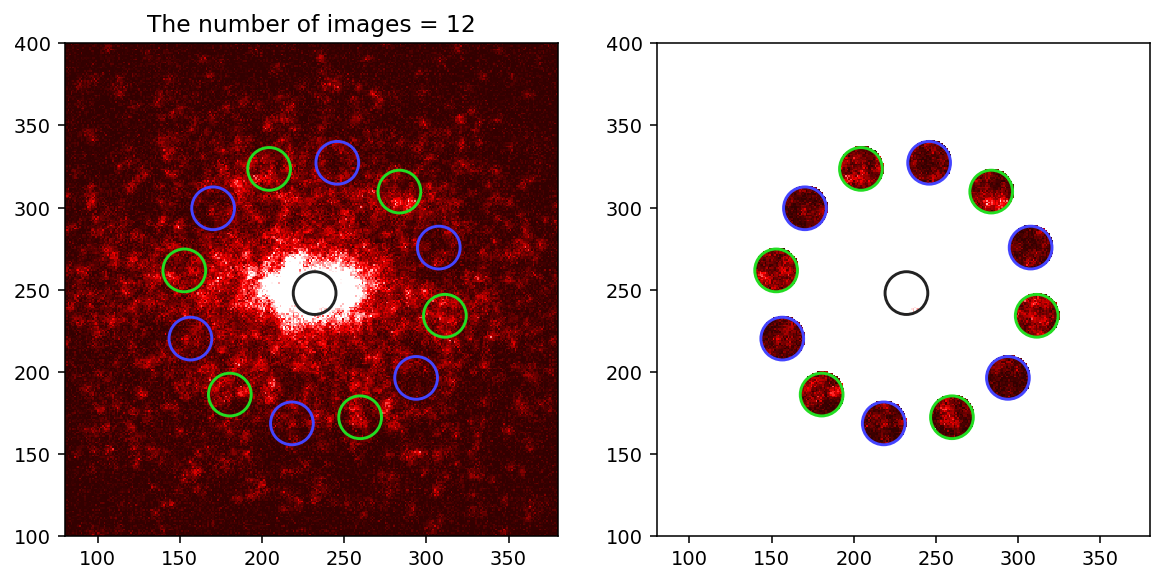

In [90]:
vmin = 0
vmax = 1000
fig =plt.figure(figsize=[10,5],dpi = 140)
ax1 = fig.add_subplot(1,2,1)
mappable =ax1.pcolormesh(np.average(unique_trans_files,axis=0), cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title("The number of images = %d"%(len(unique_trans_files)))

ax2 = fig.add_subplot(1,2,2)
for j in range(len(subROI_cx_list)):
    ax2.pcolormesh(extractCircleROI(np.average(unique_trans_files,axis=0), subROI_cx_list[j], subROI_cy_list[j], r), vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')
ax2.set_aspect('equal')
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_ylim(ylim_1,ylim_2)

for i in range(len(subROI_cx_list)):
    if i == 0:
        color = '#222222'
    elif i<len(momentum_peaks_C1_dx_list)+1:
        color = '#22dd22'
    else:
        color = '#4444ff'
    region = CirclePixelRegion(center=PixCoord(x=subROI_cx_list[i], y=subROI_cy_list[i]), radius=r)
    region.plot(ax=ax1, color=color, lw=1.5)
    region.plot(ax=ax2, color=color, lw=1.5)

In [91]:
def calculateVisibility(trans_files, subROI_cx_list, subROI_cy_list, r):
    center_list = []
    side1_list = []
    side2_list = []
    visibility_list = []
    for j in range(len(trans_files)):
        center_list.append(OpticalDensityInExtractedCircleROI(trans_files[j], subROI_cx_list[0], subROI_cy_list[0],r))
        side1_list.append(np.sum(list(map(lambda x: OpticalDensityInExtractedCircleROI(trans_files[j], subROI_cx_list[x], subROI_cy_list[x], r), range(1,len(momentum_peaks_C1_dx_list)+1,1)))))
        side2_list.append(np.sum(list(map(lambda x: OpticalDensityInExtractedCircleROI(trans_files[j], subROI_cx_list[x], subROI_cy_list[x], r), range(len(momentum_peaks_C1_dx_list)+1,len(momentum_peaks_C1_dx_list)+len(momentum_peaks_C2_dx_list)+1,1)))))
        visibility_list.append((side1_list[-1]-side2_list[-1])/(side1_list[-1]+side2_list[-1]))
    x_list = np.arange(0,len(unique_trans_files),1)
    return x_list, visibility_list, center_list

x_list, visibility_list, center_list = calculateVisibility(unique_trans_files, subROI_cx_list, subROI_cy_list, r)

Text(0.5, 0, 'Number of occurence')

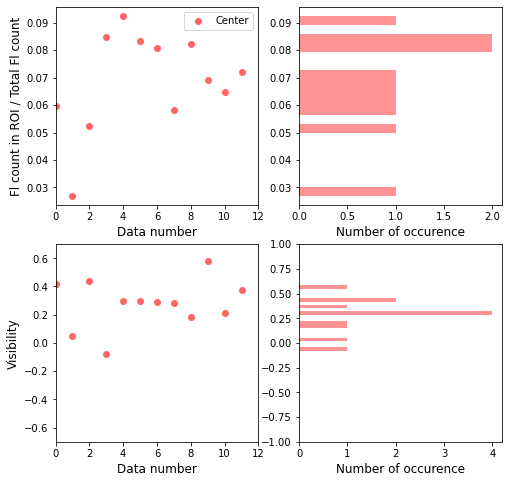

In [92]:
fig =plt.figure(figsize=[8,8])
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(x_list,center_list,  marker='o', c='#ff6666',label='Center')
ax1.set_xlabel(r'Data number',fontsize=12)
ax1.set_ylabel('Fl count in ROI / Total Fl count',fontsize=12)
ax1.set_xlim(0,len(unique_trans_files))
ax1.legend()

ax2 = fig.add_subplot(2,2,2)
ax2.hist(np.array(center_list),bins=20,color='#ff6666', alpha=0.7,orientation='horizontal')
ax2.set_xlabel('Number of occurence',fontsize=12)

ax3 = fig.add_subplot(2,2,3)
ax3.scatter(x_list,visibility_list,  marker='o', c='#ff6666',label='Visibility')
ax3.set_xlabel(r'Data number',fontsize=12)
ax3.set_ylabel('Visibility',fontsize=12)
ax3.set_xlim(0,len(unique_trans_files))
ax3.set_ylim(-0.7,0.7)

ax4 = fig.add_subplot(2,2,4)
ax4.hist(np.array(visibility_list),bins=20,color='#ff6666', alpha=0.7,orientation='horizontal')
ax4.set_ylim(-1,1)
ax4.set_xlabel('Number of occurence',fontsize=12)

In [93]:
visibility_by_unique_param = []
center_by_unique_param = []

cx = 232
cy = 248
r = 13

for i in range(len(unique_param_1)):
    for j in range(len(unique_param_2)):
        unique_param_indices = [i,j]
        unique_trans_files = createUniqueTransFiles(img_trans_list, scan_param_1, scan_param_2, unique_param_1, unique_param_2, unique_param_indices)
        subROI_cx_list, subROI_cy_list = calculateCentersOfSubROI(cx, cy, momentum_peaks_C1_dx_list, momentum_peaks_C1_dy_list, momentum_peaks_C2_dx_list, momentum_peaks_C2_dy_list)
        x_list, visibility_list, center_list = calculateVisibility(unique_trans_files, subROI_cx_list, subROI_cy_list, r)
        visibility_by_unique_param.append(np.average(visibility_list))
        center_by_unique_param.append(np.average(center_list))

In [94]:
LatticeDepth_list = np.linspace(2,7,len(unique_param_2))
Freq_list = np.linspace(0.4, 8, len(unique_param_1))
X, Y = np.meshgrid(LatticeDepth_list, Freq_list)
visibility_array = np.array(visibility_by_unique_param).reshape(len(unique_param_1), len(unique_param_2))
center_array = np.array(center_by_unique_param).reshape(len(unique_param_1), len(unique_param_2))

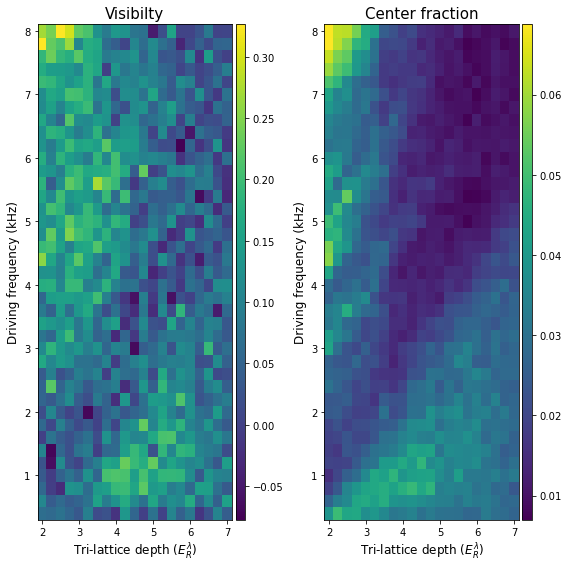

In [95]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig =plt.figure(figsize=[8,8])
ax1 = fig.add_subplot(1,2,1)
mappable = ax1.pcolormesh(X,Y,visibility_array, shading = "auto")
ax1.set_xlabel(r'Tri-lattice depth ($E_R^\lambda$)',fontsize=12)
ax1.set_ylabel('Driving frequency (kHz)',fontsize=12)
ax1.set_title('Visibilty', fontsize=15)
divider1 = make_axes_locatable(ax1)
ax_cb1 = divider1.append_axes("right",size="5%",pad=0.05)
pp=fig.colorbar(mappable,cax=ax_cb1)
pp.ax.set_title(r"", fontsize=15)

ax2 = fig.add_subplot(1,2,2)
mappable = ax2.pcolormesh(X,Y,center_array, shading = "auto")
ax2.set_xlabel(r'Tri-lattice depth ($E_R^\lambda$)',fontsize=12)
ax2.set_ylabel('Driving frequency (kHz)',fontsize=12)
ax2.set_title('Center fraction', fontsize=15)
divider2 = make_axes_locatable(ax2)
ax_cb2 = divider2.append_axes("right",size="5%",pad=0.05)
pp=fig.colorbar(mappable,cax=ax_cb2)
pp.ax.set_title(r"", fontsize=15)

plt.tight_layout()


In [70]:
np.save('TriLatticeDepth_meshgrid.npy',X)
np.save('LSfrequency_meshgrid.npy',Y)
np.save('visibility.npy',visibility_array)
np.save('center.npy',center_array)

In [106]:
LatticeDepth_list[2], Freq_list[37]

(2.5, 7.8)

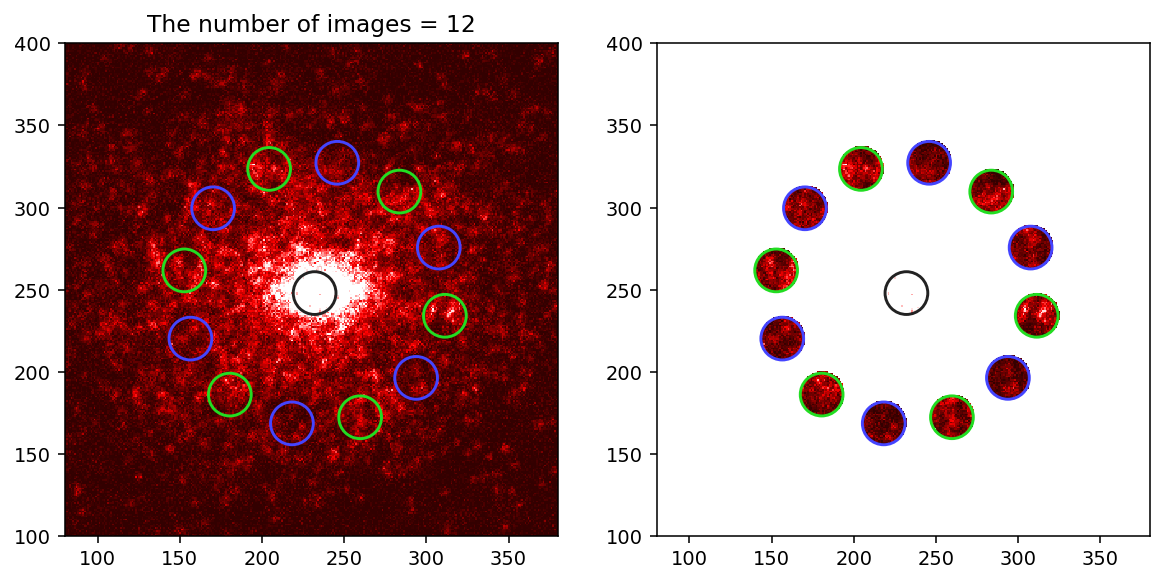

In [107]:
unique_param_indices = [37,2]
unique_trans_files = createUniqueTransFiles(postSelected_trans_files, postSelected_param_1, postSelected_param_2, unique_param_1, unique_param_2, unique_param_indices)

vmin = 0
vmax = 1000
fig =plt.figure(figsize=[10,5],dpi = 140)
ax1 = fig.add_subplot(1,2,1)
mappable =ax1.pcolormesh(np.average(unique_trans_files,axis=0), cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.set_title("The number of images = %d"%(len(unique_trans_files)))

ax2 = fig.add_subplot(1,2,2)
for j in range(len(subROI_cx_list)):
    ax2.pcolormesh(extractCircleROI(np.average(unique_trans_files,axis=0), subROI_cx_list[j], subROI_cy_list[j], r), vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')
ax2.set_aspect('equal')
ax2.set_xlim(xlim_1,xlim_2)
ax2.set_ylim(ylim_1,ylim_2)

for i in range(len(subROI_cx_list)):
    if i == 0:
        color = '#222222'
    elif i<len(momentum_peaks_C1_dx_list)+1:
        color = '#22dd22'
    else:
        color = '#4444ff'
    region = CirclePixelRegion(center=PixCoord(x=subROI_cx_list[i], y=subROI_cy_list[i]), radius=r)
    region.plot(ax=ax1, color=color, lw=1.5)
    region.plot(ax=ax2, color=color, lw=1.5)